# Climatology generator prototype

#### Date: 11 December, 2023

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

### BRAN2020 is 16TB of data over nearly 9000 `netcdf` file assests in total.
### But our ARD workflow makes the efficient `zarr` collections for this notebook

# Setup

#### required packages

In [1]:
import intake
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
#more plotting
import matplotlib.dates as mdates
import seaborn as sns

#### start a local Dask client

In [2]:
from dask.distributed import Client
#client = Client(threads_per_worker=1)
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41707,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:39783,Total threads: 4
Dashboard: /proxy/37173/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:36045,


#### ignore warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

## basic functions

In [4]:
def get_monthly_climatology(xr_object,time_coord_name = 'time',flox=True):
    if flox == True:
        monthly_climatology = xr_object.groupby(time_coord_name+'.month').mean(dim=time_coord_name,keep_attrs = True,method="cohorts", engine="flox")
    else:
        monthly_climatology = xr_object.groupby(time_coord_name+'.month').mean(dim=time_coord_name,keep_attrs = True)
    return monthly_climatology

def get_monthly_anomaly(xr_object,monthly_climatology, time_coord_name = 'time'):
    monthly_anomaly = xr_object.groupby(time_coord_name+'.month') - monthly_climatology
    return monthly_anomaly

# post-processing workflow $\Downarrow$

## load in both zarr collections

In [5]:
BRAN2020_ard_path = '/scratch/es60/ard/reanalysis/BRAN2020/'
ard_file_ID = 'BRAN2020-monthly-temp-v13112023.zarr'
ard_rcTime_file_ID = 'BRAN2020-monthly-temp-chunk4time-v13112023.zarr'

In [6]:
temp_chunked_time = xr.open_zarr(BRAN2020_ard_path + ard_rcTime_file_ID,consolidated=True)
temp_chunked = xr.open_zarr(BRAN2020_ard_path + ard_file_ID,consolidated=True)

## define El Nino and La Nina using NCAR ONI data

In [7]:
ONI_DF = pd.read_csv('/g/data/xv83/users/tm4888/data/ENSO/NCAR_ONI.csv')
ONI_DF.set_index('datetime',inplace=True)
ONI_DF.index = pd.to_datetime(ONI_DF.index)
el_nino_threshold = 0.5
la_nina_threshold = -0.5
el_nino_threshold_months = ONI_DF["ONI"].ge(el_nino_threshold)
la_nina_threshold_months = ONI_DF["ONI"].le(la_nina_threshold) 
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.rename('El Nino threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.rename('La Nina threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.diff().ne(0).cumsum().rename('El Nino event group ID')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.diff().ne(0).cumsum().rename('La Nina event group ID')], axis=1)

In [8]:
El_Nino_Series = ONI_DF.groupby('El Nino event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['El Nino threshold'] == True)
ONI_DF = pd.concat([ONI_DF, El_Nino_Series.rename('El Nino')], axis=1)
La_Nina_Series = ONI_DF.groupby('La Nina event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['La Nina threshold'] == True)
ONI_DF = pd.concat([ONI_DF, La_Nina_Series.rename('La Nina')], axis=1)

# filter BRAN2020 data by ENSO

In [9]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']
ONI_DF_BRANtime['El Nino LOGICAL'] = ONI_DF_BRANtime['El Nino'].notnull()
ONI_DF_BRANtime['La Nina LOGICAL'] = ONI_DF_BRANtime['La Nina'].notnull()

In [10]:
El_Nino_mask = ONI_DF_BRANtime['El Nino LOGICAL']
El_Nino_mask = El_Nino_mask.to_xarray()
El_Nino_mask = El_Nino_mask.rename({'datetime':'Time'})
sync_Time = temp_chunked_time.Time
El_Nino_mask['Time'] = sync_Time

In [11]:
La_Nina_mask = ONI_DF_BRANtime['La Nina LOGICAL']
La_Nina_mask = La_Nina_mask.to_xarray()
La_Nina_mask = La_Nina_mask.rename({'datetime':'Time'})
sync_Time = temp_chunked_time.Time
La_Nina_mask['Time'] = sync_Time

In [12]:
ONI_DF_BRANtime['Neutral LOGICAL'] = (ONI_DF_BRANtime['El Nino LOGICAL'] == False) & (ONI_DF_BRANtime['La Nina LOGICAL'] == False)

In [13]:
ONI_DF_BRANtime['El Nino LOGICAL'].sum()

70

In [14]:
ONI_DF_BRANtime['La Nina LOGICAL'].sum()

119

In [15]:
ONI_DF_BRANtime['Neutral LOGICAL'].sum()

171

# Test if they add to 360

In [16]:
ONI_DF_BRANtime['El Nino LOGICAL'].sum() + ONI_DF_BRANtime['La Nina LOGICAL'].sum()+ONI_DF_BRANtime['Neutral LOGICAL'].sum() == 360

True

##  mask events in both space and time chunked versions

In [17]:
El_Nino_mask_0_1 = El_Nino_mask.to_dataframe().replace({True: 1, False: 0}).to_xarray()
La_Nina_mask_0_1 = La_Nina_mask.to_dataframe().replace({True: 1, False: 0}).to_xarray()

In [18]:
El_Nino_mask_TIMES = El_Nino_mask_0_1['Time'].where(El_Nino_mask,drop=True)
La_Nina_mask_TIMES = La_Nina_mask_0_1['Time'].where(La_Nina_mask,drop=True)

In [19]:
El_Nino_temp_chunked_time = temp_chunked_time.sel({'Time':El_Nino_mask_TIMES})
La_Nina_temp_chunked_time = temp_chunked_time.sel({'Time':La_Nina_mask_TIMES})

El_Nino_temp_chunked = temp_chunked.sel({'Time':El_Nino_mask_TIMES})
La_Nina_temp_chunked = temp_chunked.sel({'Time':La_Nina_mask_TIMES})

# Climatologies

In [20]:
temp_monthly_climatology = get_monthly_climatology(temp_chunked_time, time_coord_name = 'Time')
temp_monthly_climatology_rc = temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})
#El Nino
El_Nino_temp_monthly_climatology = get_monthly_climatology(El_Nino_temp_chunked_time, time_coord_name = 'Time')
El_Nino_temp_monthly_climatology_rc = El_Nino_temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})
#La Nina
La_Nina_temp_monthly_climatology = get_monthly_climatology(La_Nina_temp_chunked_time, time_coord_name = 'Time')
La_Nina_temp_monthly_climatology_rc = La_Nina_temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})

# Anomalies

In [21]:
temp_anomaly = get_monthly_anomaly(temp_chunked,temp_monthly_climatology_rc,time_coord_name='Time')
El_Nino_temp_anomaly = get_monthly_anomaly(El_Nino_temp_chunked,El_Nino_temp_monthly_climatology_rc,time_coord_name='Time')
La_Nina_temp_anomaly = get_monthly_anomaly(La_Nina_temp_chunked,La_Nina_temp_monthly_climatology_rc,time_coord_name='Time')

# Mean, Median, Max , Min, Std, 05 & 95 quantiles

In [22]:
El_Nino_mean = El_Nino_temp_chunked_time.mean('Time')
El_Nino_median = El_Nino_temp_chunked_time.median('Time')
El_Nino_max = El_Nino_temp_chunked_time.max('Time')
El_Nino_min = El_Nino_temp_chunked_time.min('Time')
El_Nino_std = El_Nino_temp_chunked_time.std('Time')
El_Nino_quant = El_Nino_temp_chunked_time.quantile([0.05,0.95],skipna=False,dim='Time')

In [23]:
La_Nina_mean = La_Nina_temp_chunked_time.mean('Time')
La_Nina_median = La_Nina_temp_chunked_time.median('Time')
La_Nina_max = La_Nina_temp_chunked_time.max('Time')
La_Nina_min = La_Nina_temp_chunked_time.min('Time')
La_Nina_std = La_Nina_temp_chunked_time.std('Time')
La_Nina_quant = La_Nina_temp_chunked_time.quantile([0.05,0.95],skipna=False,dim='Time')

In [24]:
mean = temp_chunked_time.mean('Time')
median = temp_chunked_time.median('Time')
max = temp_chunked_time.max('Time')
min = temp_chunked_time.min('Time')
std = temp_chunked_time.std('Time')
quant = temp_chunked_time.quantile([0.05,0.95],skipna=False,dim='Time')

## heatmap & month counts

### make table for average over certain region

In [25]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = temp_anomaly.temp.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'Time':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_of_BRAN2020_anomaly = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_of_BRAN2020_anomaly = spatial_mean_of_BRAN2020_anomaly.compute()

CPU times: user 8.59 s, sys: 1.12 s, total: 9.71 s
Wall time: 39.4 s


In [26]:
spatial_mean_of_BRAN2020_anomaly_DF = spatial_mean_of_BRAN2020_anomaly.to_dataframe()
spatial_mean_of_BRAN2020_anomaly_DF['year'] = pd.DatetimeIndex(spatial_mean_of_BRAN2020_anomaly_DF.index).year

In [27]:
heatmap_data = spatial_mean_of_BRAN2020_anomaly_DF.pivot_table(index='month', columns='year', values='temp')

#### stacked heatmap plot

In [28]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']

In [29]:
event_data_EN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='El Nino',dropna=False).fillna('')
event_data_LN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='La Nina',dropna=False).fillna('')

Text(0.5, 1.0, 'Month by Year BRAN2020 anomalies in ONI (Nino3.4) region\n ONI values shown for defined ENSO events')

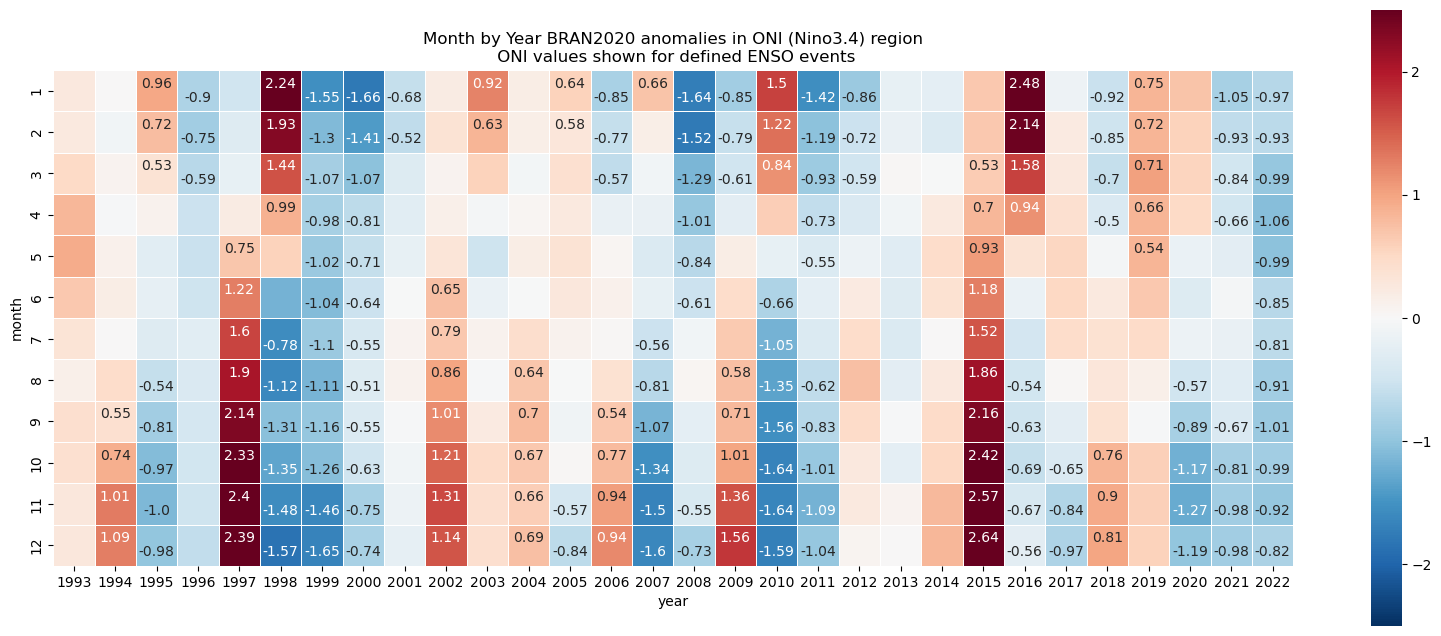

In [30]:
plt.figure(figsize=(20,8))
sns.heatmap(heatmap_data, annot=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_LN, annot_kws={'va':'top'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_EN, annot_kws={'va':'bottom'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
plt.title('Month by Year BRAN2020 anomalies in ONI (Nino3.4) region\n ONI values shown for defined ENSO events')

#### count of events in BRAN2020 period
El Nino = 8 events ( weak - strong ) as defined by ONI<br>
La Nina = 10 events ( weak - strong ) as defined by ONI <br>
El Nino months total = 70 = 19%
La Nina months total = 119 = 33%
Neutral months total = 171 = 48%


### count number of samples for each month for both events

In [31]:
El_Nino_number_month_samples = El_Nino_temp_chunked_time.Time.groupby('Time.month').count()
La_Nina_number_month_samples = La_Nina_temp_chunked_time.Time.groupby('Time.month').count()

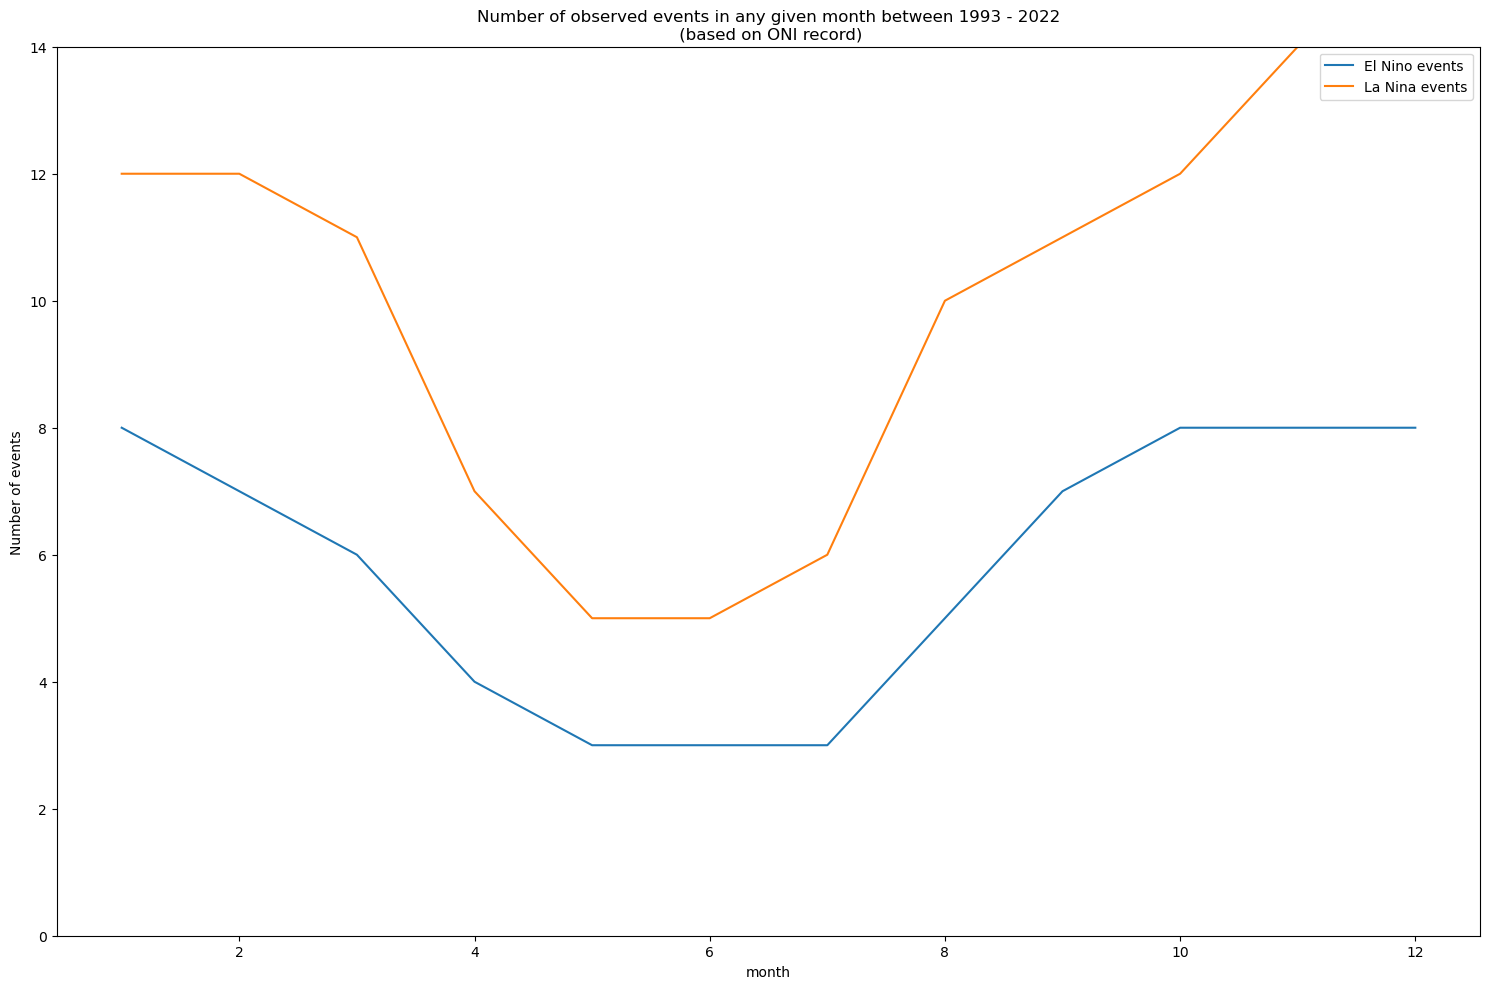

In [33]:
plt.figure(figsize=(15,10))
EN= El_Nino_number_month_samples.plot.line(label='El Nino events')
LN = La_Nina_number_month_samples.plot.line(label='La Nina events')
plt.title('Number of observed events in any given month between 1993 - 2022\n (based on ONI record)')
plt.ylabel('Number of events')
ax = plt.gca()
ax.set_ylim([0, 14])
plt.legend()
plt.tight_layout()
plt.show()

# make BRAN2020 temperature objects

In [34]:
mean = mean.rename({'temp':'mean_temp'})
median = median.rename({'temp':'median_temp'})
max = max.rename({'temp':'max_temp'})
min = min.rename({'temp':'min_temp'})
std = std.rename({'temp':'std_temp'})
quant = quant.rename({'temp':'quantile_temp'})
#El_Nino_
El_Nino_mean = El_Nino_mean.rename({'temp':'El_Nino_mean_temp'})
El_Nino_median = El_Nino_median.rename({'temp':'El_Nino_median_temp'})
El_Nino_max = El_Nino_max.rename({'temp':'El_Nino_max_temp'})
El_Nino_min = El_Nino_min.rename({'temp':'El_Nino_min_temp'})
El_Nino_std = El_Nino_std.rename({'temp':'El_Nino_std_temp'})
El_Nino_quant = El_Nino_quant.rename({'temp':'El_Nino_quantile_temp'})
#La_Nina_
La_Nina_mean = La_Nina_mean.rename({'temp':'La_Nina_mean_temp'})
La_Nina_median = La_Nina_median.rename({'temp':'La_Nina_median_temp'})
La_Nina_max = La_Nina_max.rename({'temp':'La_Nina_max_temp'})
La_Nina_min = La_Nina_min.rename({'temp':'La_Nina_min_temp'})
La_Nina_std = La_Nina_std.rename({'temp':'La_Nina_std_temp'})
La_Nina_quant = La_Nina_quant.rename({'temp':'La_Nina_quantile_temp'})

In [35]:
BRAN2020_temperature_stats = xr.merge([mean,median,max,min,std,
                                      El_Nino_mean,El_Nino_median,El_Nino_max,El_Nino_min,El_Nino_std,
                                      La_Nina_mean,La_Nina_median,La_Nina_max,La_Nina_min,La_Nina_std])

In [36]:
BRAN2020_temperature_stats.nbytes/1e9

16.524041208

In [37]:
BRAN2020_temperature_stats_rc = BRAN2020_temperature_stats.chunk({'st_ocean':-1,'xt_ocean':360})

In [38]:
BRAN2020_temperature_quant = xr.merge([quant,
                                      El_Nino_quant,
                                      La_Nina_quant])

In [40]:
BRAN2020_temperature_quant.nbytes/1e9

13.219241224

In [41]:
BRAN2020_temperature_quant_rc = BRAN2020_temperature_quant.chunk({'xt_ocean':3600})
BRAN2020_temperature_quant_rc

<xarray.Dataset>
Dimensions:                (st_ocean: 51, quantile: 2, yt_ocean: 1500,
                            xt_ocean: 3600)
Coordinates:
  * st_ocean               (st_ocean) float64 2.5 7.5 ... 3.603e+03 4.509e+03
  * xt_ocean               (xt_ocean) float64 0.05 0.15 0.25 ... 359.9 360.0
  * yt_ocean               (yt_ocean) float64 -74.95 -74.85 ... 74.85 74.95
  * quantile               (quantile) float64 0.05 0.95
Data variables:
    quantile_temp          (quantile, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(2, 1, 1500, 3600), meta=np.ndarray>
    El_Nino_quantile_temp  (quantile, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(2, 1, 1500, 3600), meta=np.ndarray>
    La_Nina_quantile_temp  (quantile, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(2, 1, 1500, 3600), meta=np.ndarray>

### Climatology

In [42]:
temp_monthly_climatology_rc = temp_monthly_climatology_rc.rename({'temp':'climatological_temp'})
El_Nino_temp_monthly_climatology_rc = El_Nino_temp_monthly_climatology_rc.rename({'temp':'El_Nino_climatological_temp'})
La_Nina_temp_monthly_climatology_rc = La_Nina_temp_monthly_climatology_rc.rename({'temp':'La_Nina_climatological_temp'})

In [43]:
BRAN2020_temperature_climatology = xr.merge([temp_monthly_climatology_rc,El_Nino_temp_monthly_climatology_rc,La_Nina_temp_monthly_climatology_rc])

In [44]:
BRAN2020_temperature_climatology.nbytes/1e9

39.657641304

# write out results in NetCDF

In [45]:
write_path = '/g/data/es60/users/thomas_moore/clim_demo_results/'

In [ ]:
%%time
settings = {'chunksizes':(51,1500,360)}
encoding = {var: settings for var in BRAN2020_temperature_stats_rc.data_vars}
BRAN2020_temperature_stats_rc.to_netcdf(write_path+'BRAN2020_temperature_stats.nc')

/g/data/v14/tm4888/miniconda3/envs/busecke_etal_grl_2019_omz_euc/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


# can we load and use these NetCDF files?

In [ ]:
a = xr.open_mfdataset(write_path+'BRAN2020_temperature_stats.nc',parallel=True,chunks = {'st_ocean':51, 'yt_ocean':1500, 'xt_ocean':360})
b = xr.open_mfdataset(write_path+'BRAN2020_temperature_climatology.nc',parallel=True,chunks = {'month':1,'st_ocean':10, 'yt_ocean':1500, 'xt_ocean':3600})
c = xr.open_mfdataset(write_path+'BRAN2020_temperature_quant.nc',parallel=True,chunks = {'quantile':2,'st_ocean':1, 'yt_ocean':1500, 'xt_ocean':3600})

In [ ]:
b

# The End

In [ ]:
#client.shutdown()